# MC mixer

Looking at data is a serious taboo at CMS so we try to build MC to look like the data.  Several MC samples are used to model the ttbar and Drell-Yan backgrounds and must be sampled in proportion to their cross-section for the sake of making data-like mixtures.


In [7]:
#imports
%cd '/home/naodell/work/CMS/amumu'
%matplotlib notebook

import os, sys
from timeit import default_timer as timer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm_notebook

import nllfitter.plot_tools as pt

pt.set_new_tdr()
matplotlib.rcParams['figure.figsize'] = (8,8)

/home/naodell/work/CMS/amumu


In [8]:
#configuration and data retrieval
period = 2016
if period ==  2012:
    datasets = ['muon_2012A', 'muon_2012B', 'muon_2012C', 'muon_2012D']
elif period == 2016:
    datasets = [
                'muon_2016B', 'muon_2016C', 'muon_2016D'
                'muon_2016E', 'muon_2016F', 'muon_2016G'
                'muon_2016H',
               ]
mcsets = [
            'ttbar_lep', 'ttbar_semilep', 
            'zjets_m-50', 'zjets_m-10to50',  
            'z1jets_m-50', 'z1jets_m-10to50',
            'z2jets_m-50', 'z2jets_m-10to50',
            'z3jets_m-50', 'z3jets_m-10to50',
            'z4jets_m-10to50', 'z4jets_m-50',                   
            'bprime_t-channel'
            #'fcnc_s-channel', 'fcnc_tt_semilep'
            ]
preselection = '(lepton1_pt > 25 and abs(lepton1_eta) < 2.1 \
                and lepton2_pt > 25 and abs(lepton2_eta) < 2.1 \
                and lepton1_q != lepton2_q \
                and 12 < dilepton_mass < 70) \
                and n_bjets >= 1 \
                and ((n_bjets == 1 and n_jets == 0 and n_fwdjets == 1) \
                or (n_bjets >= 1 and n_bjets + n_jets == 2 and n_fwdjets == 0 \
                and met_mag < 40 and four_body_delta_phi > 2.5))'

dm_mc = pt.DataManager(input_dir     = 'data/flatuples/mumu_period'.format(period),
                       dataset_names = mcsets,                       
                       selection     = 'mumu',
                       period        = period,
                       scale         = 19.8e3 if period == 2012 else 12e3,
                       cuts          = preselection,
                       combine       = False
                    )

dm_data = pt.DataManager(input_dir     = 'data/flatuples/mumu_2016',
                         dataset_names = datasets,                       
                         selection     = 'mumu',
                         period        = period,
                         scale         = 1,
                         cuts          = preselection,
                         combine       = True
                        )

Loading dataframes: 100%|███████████████| 13.0/13.0 [00:01<00:00, 7.72it/s]
Loading dataframes: 100%|███████████████| 4.00/4.00 [00:00<00:00, 6.41it/s]


In order to prepare a sample from that datasets we have available, it will be important to know the contribution from each of those datasets taking into account their cross sections.  

In [9]:
# calculate proportions from each dataset
conditions    = ['preselection']
table_raw = dm_mc.print_yields(datasets, 
                               conditions = conditions, 
                               do_string  = False,
                               mc_scale   = False
                              )
table_scaled = dm_mc.print_yields(datasets, 
                                  conditions = conditions, 
                                  do_string  = False,
                                  mc_scale   = True
                                 )
table = pd.concat([table_raw, table_scaled], axis=1)
table.columns = ['raw', 'scaled']
table['scaling'] = table.raw/table.scaled
table

,raw,scaled,scaling
ttbar_lep,9731.0,416.454560,23.366295
ttbar_semilep,65.0,5.386560,12.067070
zjets_m-50,64.0,5.118264,12.504241
z1jets_m-50,36.0,19.263143,1.868854
z2jets_m-50,374.0,74.933413,4.991098
z3jets_m-50,300.0,33.816154,8.871500
z4jets_m-50,143.0,11.790590,12.128315
zjets_m-10to50,15.0,0.000000,inf
z1jets_m-10to50,6.0,3.795238,1.580928
z2jets_m-10to50,304.0,74.366694,4.087851


Based on the proportion in the *scaled* column, I prepare an admixture of the different background components.  For the signal I fix the scaling so that the yields agree with the nominal selection (so roughly 45 events).  I probably will refine this so that the the significance agrees with the nominal selection, but these things should really be the same.

In [10]:
table.loc['background', 'scaled']
features = ['lepton1_pt', 'lepton1_eta', 'lepton1_q', 
            'lepton2_pt', 'lepton2_eta', 'lepton2_q',
            'dilepton_mass', 'dilepton_pt', 
            'dilepton_pt_over_m', 'dilepton_b_mass', 'dilepton_j_mass', 
            'dijet_mass', 'met_mag', 'four_body_delta_phi',
            'n_bjets', 'n_jets', 'n_fwdjets']
 
nsims = 100
for i in tqdm_notebook(range(nsims),
                   desc       = 'scanning',
                   unit_scale = True,
                   #ncols      = 75,
                   total      = nsims
                  ):
    mc = []
    for dataset in datasets:
        n_events = int(table.loc[dataset, 'scaled'])
        df = dm_mc.get_dataframe(dataset)
        if df.weight[df.weight != 0].shape[0] < n_events or df.weight.sum() == 0:
            continue
            
        data = df.sample(n=n_events, weights='weight', axis=0)[features]
        data['sample_type'] = dm_mc._lut_datasets.loc[dataset].label
        mc.append(data)

    mc = pd.concat(mc)
    mc.to_csv('data/mc_mixes_bprime/dimuon_{0}_{1}.csv'.format(i, period), index=False, sep=' ')

background = mc.query('sample_type != "bprime_t-channel"')
signal = mc.query('sample_type == "bprime_t-channel"')

# background = mc.query('sample_type != "fcnc"')
# signal = mc.query('sample_type == "fcnc"')

To make sure the mixture is done properly, I compare the background and background plus signal mixtures to the data.

<IPython.core.display.Javascript object>


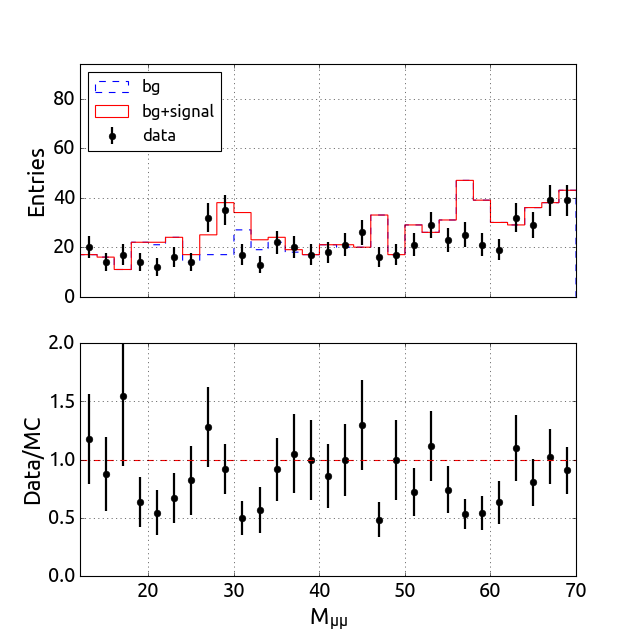

In [11]:
# Get data for validation and MC for mixing
data = dm_data.get_dataframe('data')['dilepton_mass'].values
bg   = background['dilepton_mass'].values
sig  = signal['dilepton_mass'].values

# convert data to histogram with errorbars
x, y, yerr = pt.hist_to_errorbar(data,
                                 nbins = 29,
                                 xlim  = (12, 70)
                                ) 

# overlays
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
h_bg, b, _   = ax1.hist(bg, bins=29, range=(12, 70), histtype='step', linestyle='--', color='b')
h_sig, b, _  = ax1.hist(sig, bins=29, range=(12, 70), histtype='step', bottom=h_bg, color='r')
eb           = ax1.errorbar(x, y, yerr, fmt='ko', capsize=0, elinewidth=2)

ax1.legend(['bg', 'bg+signal', 'data'], loc=2, fontsize='small')
ax1.set_ylabel(r'Entries')
ax1.set_ylim(0, 2*np.max(h_bg))
ax1.set_xlim(12, 70)
ax1.grid()

# ratio
ratio = y/(h_bg+h_sig)
ratio_err = pt.ratio_errors(y, h_bg+h_sig)
ax2.errorbar(x, ratio, ratio_err, fmt='ko', capsize=0, elinewidth=2)
ax2.plot([12, 70], [1, 1], 'r--')
ax2.set_xlabel(r'$\sf M_{\mu\mu}$')
ax2.set_ylim(0., 2.)
ax2.grid()
ax2.set_ylabel(r'Data/MC')

fig.savefig('plots/mc_mix_validate.pdf')
plt.show()

Hopefully the agreement looks good...